# Comprehensive Feature Analysis for PD Detection

**Goal**: Deep dive into extractable features to find optimal set for PD vs Control classification

Enhanced: 413 features (59 channels × 7 feature types)
  - 295 band power features
  - 59 spectral entropy features
  - 59 theta/alpha ratio features

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
import sys
from scipy import stats
from sklearn.feature_selection import mutual_info_classif, f_classif
import json
import warnings
warnings.filterwarnings('ignore')

# Setup paths
sys.path.append(str(Path.cwd() / 'modules'))
from modules.path_module import *
from modules.feature_extraction import extract_features_from_dataset

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (20, 10)


## 1. Load Data 

In [2]:
processed_path = processed_datapath()

train_data = joblib.load(processed_path / 'train_data.pkl')
val_data   = joblib.load(processed_path / 'val_data.pkl')
test_data  = joblib.load(processed_path / 'test_data.pkl')

with open(processed_path / 'metadata.json', 'r') as f:
    metadata = json.load(f)

## 2. Feature extraction


In [3]:
# Extract features from train+val only (NO test set!)
all_data = train_data + val_data

# Use unified feature extraction module
X_all, y_all, feature_info = extract_features_from_dataset(
    all_data)

print(f"\n Feature extraction complete!")
print(f"  Shape: {X_all.shape}")
print(f"  Control samples: {np.sum(y_all == 0)}")
print(f"  PD samples: {np.sum(y_all == 1)}")



 Feature extraction complete!
  Shape: (504, 413)
  Control samples: 252
  PD samples: 252


## 3. Statistical Analysis


In [4]:
X_control = X_all[y_all == 0]
X_pd = X_all[y_all == 1]

print(f"  Metrics: T-test, Cohen's d, Mutual Information, F-score")

feature_stats = []

for feat_idx in range(X_all.shape[1]):
    control_vals = X_control[:, feat_idx]
    pd_vals = X_pd[:, feat_idx]

    # T-test
    t_stat, p_value = stats.ttest_ind(control_vals, pd_vals, equal_var=False)

    # Effect size (Cohen's d)
    pooled_std = np.sqrt((np.std(control_vals)**2 + np.std(pd_vals)**2) / 2)
    cohens_d = (np.mean(pd_vals) - np.mean(control_vals)) / pooled_std if pooled_std > 0 else 0

    # Mean values
    control_mean = np.mean(control_vals)
    pd_mean = np.mean(pd_vals)

    feature_stats.append({
        'feature_idx': feat_idx,
        'name': feature_info[feat_idx]['name'],
        'channel': feature_info[feat_idx]['channel'],
        'band': feature_info[feat_idx]['band'],
        'type': feature_info[feat_idx]['type'],
        'control_mean': control_mean,
        'pd_mean': pd_mean,
        'mean_diff': pd_mean - control_mean,
        'mean_diff_pct': ((pd_mean - control_mean) / control_mean * 100) if control_mean != 0 else 0,
        't_stat': t_stat,
        'p_value': p_value,
        'cohens_d': cohens_d,
        'abs_cohens_d': abs(cohens_d)
    })

# Compute MI and F-scores
print("Computing mutual information and F-scores...")
mi_scores = mutual_info_classif(X_all, y_all, random_state=42)
f_scores, f_pvalues = f_classif(X_all, y_all)

for i, stat in enumerate(feature_stats):
    stat['mi_score'] = mi_scores[i]
    stat['f_score'] = f_scores[i]
    stat['f_pvalue'] = f_pvalues[i]

df_stats = pd.DataFrame(feature_stats)

print(f"  Dataframe shape: {df_stats.shape}")

# Multiple comparison correction (Bonferroni)
bonferroni_threshold = 0.05 / X_all.shape[1]
n_significant = (df_stats['p_value'] < bonferroni_threshold).sum()

print(f"\nMultiple Comparison Correction:")
print(f"  Bonferroni threshold: {bonferroni_threshold:.2e}")
print(f"  Significant features (p < {bonferroni_threshold:.2e}): {n_significant}/{X_all.shape[1]}")

  Metrics: T-test, Cohen's d, Mutual Information, F-score


Computing mutual information and F-scores...
  Dataframe shape: (413, 16)

Multiple Comparison Correction:
  Bonferroni threshold: 1.21e-04
  Significant features (p < 1.21e-04): 33/413


## 5. Rank Features by Combined Score


In [5]:
# Normalize scores
df_stats['mi_norm'] = (df_stats['mi_score'] - df_stats['mi_score'].min()) / (df_stats['mi_score'].max() - df_stats['mi_score'].min())
df_stats['f_norm'] = (df_stats['f_score'] - df_stats['f_score'].min()) / (df_stats['f_score'].max() - df_stats['f_score'].min())
df_stats['cohens_norm'] = (df_stats['abs_cohens_d'] - df_stats['abs_cohens_d'].min()) / (df_stats['abs_cohens_d'].max() - df_stats['abs_cohens_d'].min())

# Combined score (average of normalized metrics)
df_stats['combined_score'] = (df_stats['mi_norm'] + df_stats['f_norm'] + df_stats['cohens_norm']) / 3

# Sort by combined score
df_ranked = df_stats.sort_values('combined_score', ascending=False).reset_index(drop=True)
df_ranked['rank'] = df_ranked.index + 1

print(f"\nTop 30 Most Discriminative Features:")
print(f"{'Rank':<6} {'Feature':<25} {'Type':<18} {'Cohen d':<10} {'MI':<8} {'F-score':<8}")
print("="*100)

for i in range(min(30, len(df_ranked))):
    row = df_ranked.iloc[i]
    print(f"{row['rank']:<6} {row['name']:<25} {row['type']:<18} {row['cohens_d']:>9.3f}  {row['mi_score']:>7.4f}  {row['f_score']:>7.2f}")


Top 30 Most Discriminative Features:
Rank   Feature                   Type               Cohen d    MI       F-score 
1      gamma_ch19                band_power            -0.505   0.1423    32.04
2      theta_ch43                band_power             0.543   0.0840    36.94
3      theta_ch42                band_power             0.573   0.0571    41.17
4      theta_ch12                band_power             0.532   0.0909    35.46
5      theta_ch13                band_power             0.530   0.0738    35.30
6      theta_ch46                band_power             0.542   0.0597    36.88
7      gamma_ch48                band_power            -0.526   0.0636    34.67
8      theta_ch38                band_power             0.530   0.0336    35.28
9      theta_ch8                 band_power             0.495   0.0589    30.72
10     theta_ch39                band_power             0.533   0.0225    35.63
11     theta_ch15                band_power             0.495   0.0497    30.81
1

## 5. Analyze Feature Type Distribution

In [6]:
# Count how many of each type in top features
for n in [5, 10, 15, 20, 25, 28, 30]:
    top_n = df_ranked.head(n)
    type_counts = top_n['type'].value_counts()

    print(f"\nTop {n} features:")
    for ftype in ['band_power', 'spectral_entropy', 'theta_alpha_ratio']:
        count = type_counts.get(ftype, 0)
        pct = count / n * 100
        print(f"  {ftype:<20}: {count:>2}/{n} ({pct:>5.1f}%)")

n_opt = 28
top_features = df_ranked.head(n_opt)
band_distribution = (
    top_features['band']
    .value_counts()
    .sort_index()
    .to_dict()
)


Top 5 features:
  band_power          :  5/5 (100.0%)
  spectral_entropy    :  0/5 (  0.0%)
  theta_alpha_ratio   :  0/5 (  0.0%)

Top 10 features:
  band_power          : 10/10 (100.0%)
  spectral_entropy    :  0/10 (  0.0%)
  theta_alpha_ratio   :  0/10 (  0.0%)

Top 15 features:
  band_power          : 15/15 (100.0%)
  spectral_entropy    :  0/15 (  0.0%)
  theta_alpha_ratio   :  0/15 (  0.0%)

Top 20 features:
  band_power          : 20/20 (100.0%)
  spectral_entropy    :  0/20 (  0.0%)
  theta_alpha_ratio   :  0/20 (  0.0%)

Top 25 features:
  band_power          : 23/25 ( 92.0%)
  spectral_entropy    :  2/25 (  8.0%)
  theta_alpha_ratio   :  0/25 (  0.0%)

Top 28 features:
  band_power          : 25/28 ( 89.3%)
  spectral_entropy    :  3/28 ( 10.7%)
  theta_alpha_ratio   :  0/28 (  0.0%)

Top 30 features:
  band_power          : 27/30 ( 90.0%)
  spectral_entropy    :  3/30 ( 10.0%)
  theta_alpha_ratio   :  0/30 (  0.0%)


## 8. Save 


In [7]:
output_dir = snn_results_path()
output_dir.mkdir(parents=True, exist_ok=True)

feature_config = {
    'version': 'comprehensive_v1',
    'type': 'selected_channel_bands_comprehensive',
    'n_features': n_opt,
    'selected_indices': top_features['feature_idx'].tolist(),
    'feature_names': top_features['name'].tolist(),
    'feature_types': top_features['type'].tolist(),
    'band_distribution': top_features['band'].value_counts().to_dict(),
    'feature_type_distribution': {
        'band_power': int(top_features['type'].value_counts().get('band_power', 0)),
        'spectral_entropy': int(top_features['type'].value_counts().get('spectral_entropy', 0)),
        'theta_alpha_ratio': int(top_features['type'].value_counts().get('theta_alpha_ratio', 0))
    },
    'description': f'Optimal feature configuration with {n_opt} features based on comprehensive analysis'
}

config_path = output_dir / 'optimal_feature_config_comprehensive.json'

with open(config_path, 'w') as f:
    json.dump(feature_config, f, indent=2)

print(f"✓ Feature configuration saved: {config_path}")

df_ranked.to_csv(output_dir / 'all_features_ranked_comprehensive.csv', index=False)


✓ Feature configuration saved: c:\Users\KSWes\MemSNNforPD\MemSNNforPD-master\results\snn\optimal_feature_config_comprehensive.json


## 9. Feature Importance Visualizations


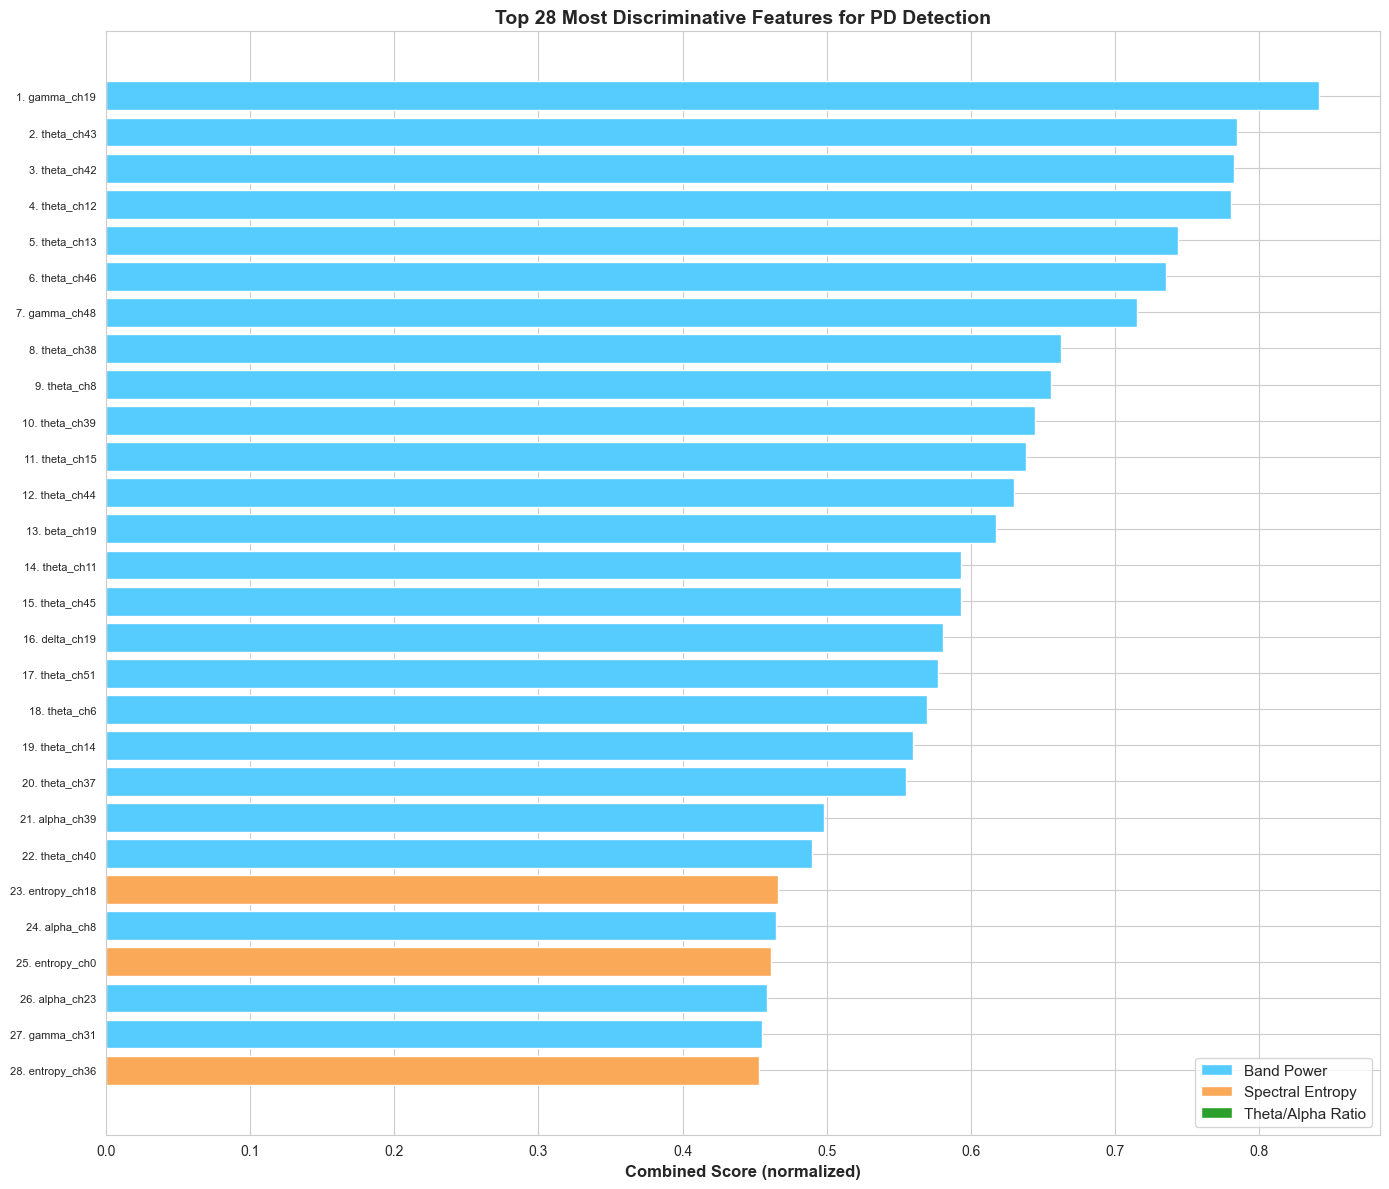

✓ Saved: top_28_features_combined_score.png


In [8]:
# 1. Bar plot of Top 28 Features by Combined Score
fig, ax = plt.subplots(figsize=(14, 12))

top_28 = df_ranked.head(28).copy()
colors = {'band_power': "#55CBFE", 'spectral_entropy': "#FAA959", 'theta_alpha_ratio': '#2ca02c'}
bar_colors = [colors[t] for t in top_28['type']]

ax.barh(range(len(top_28)), top_28['combined_score'].values, color=bar_colors)
ax.set_yticks(range(len(top_28)))
ax.set_yticklabels([f"{i+1}. {name}" for i, name in enumerate(top_28['name'].values)], fontsize=8)
ax.set_xlabel('Combined Score (normalized)', fontsize=12, fontweight='bold')
ax.set_title('Top 28 Most Discriminative Features for PD Detection', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors['band_power'], label='Band Power'),
    Patch(facecolor=colors['spectral_entropy'], label='Spectral Entropy'),
    Patch(facecolor=colors['theta_alpha_ratio'], label='Theta/Alpha Ratio')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=11)

plt.tight_layout()
plt.savefig(output_dir / 'top_28_features_combined_score.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: top_28_features_combined_score.png")

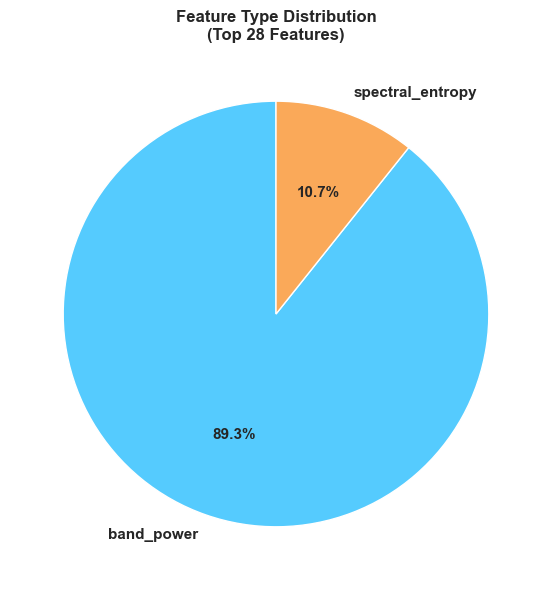

✓ Saved: feature_type_distribution_28.png


In [9]:
# Feature Type Distribution - Top 28 (single pie chart)
fig, ax = plt.subplots(figsize=(6, 6))

type_counts_28 = df_ranked.head(28)['type'].value_counts()
colors_pie = ["#55CBFE", "#FAA959", "#79fc79"]

ax.pie(
    type_counts_28.values,
    labels=type_counts_28.index,
    autopct='%1.1f%%',
    colors=colors_pie,
    startangle=90,
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)

ax.set_title(
    'Feature Type Distribution\n(Top 28 Features)',
    fontsize=12,
    fontweight='bold'
)

plt.tight_layout()
plt.savefig(output_dir / 'feature_type_distribution_28.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: feature_type_distribution_28.png")


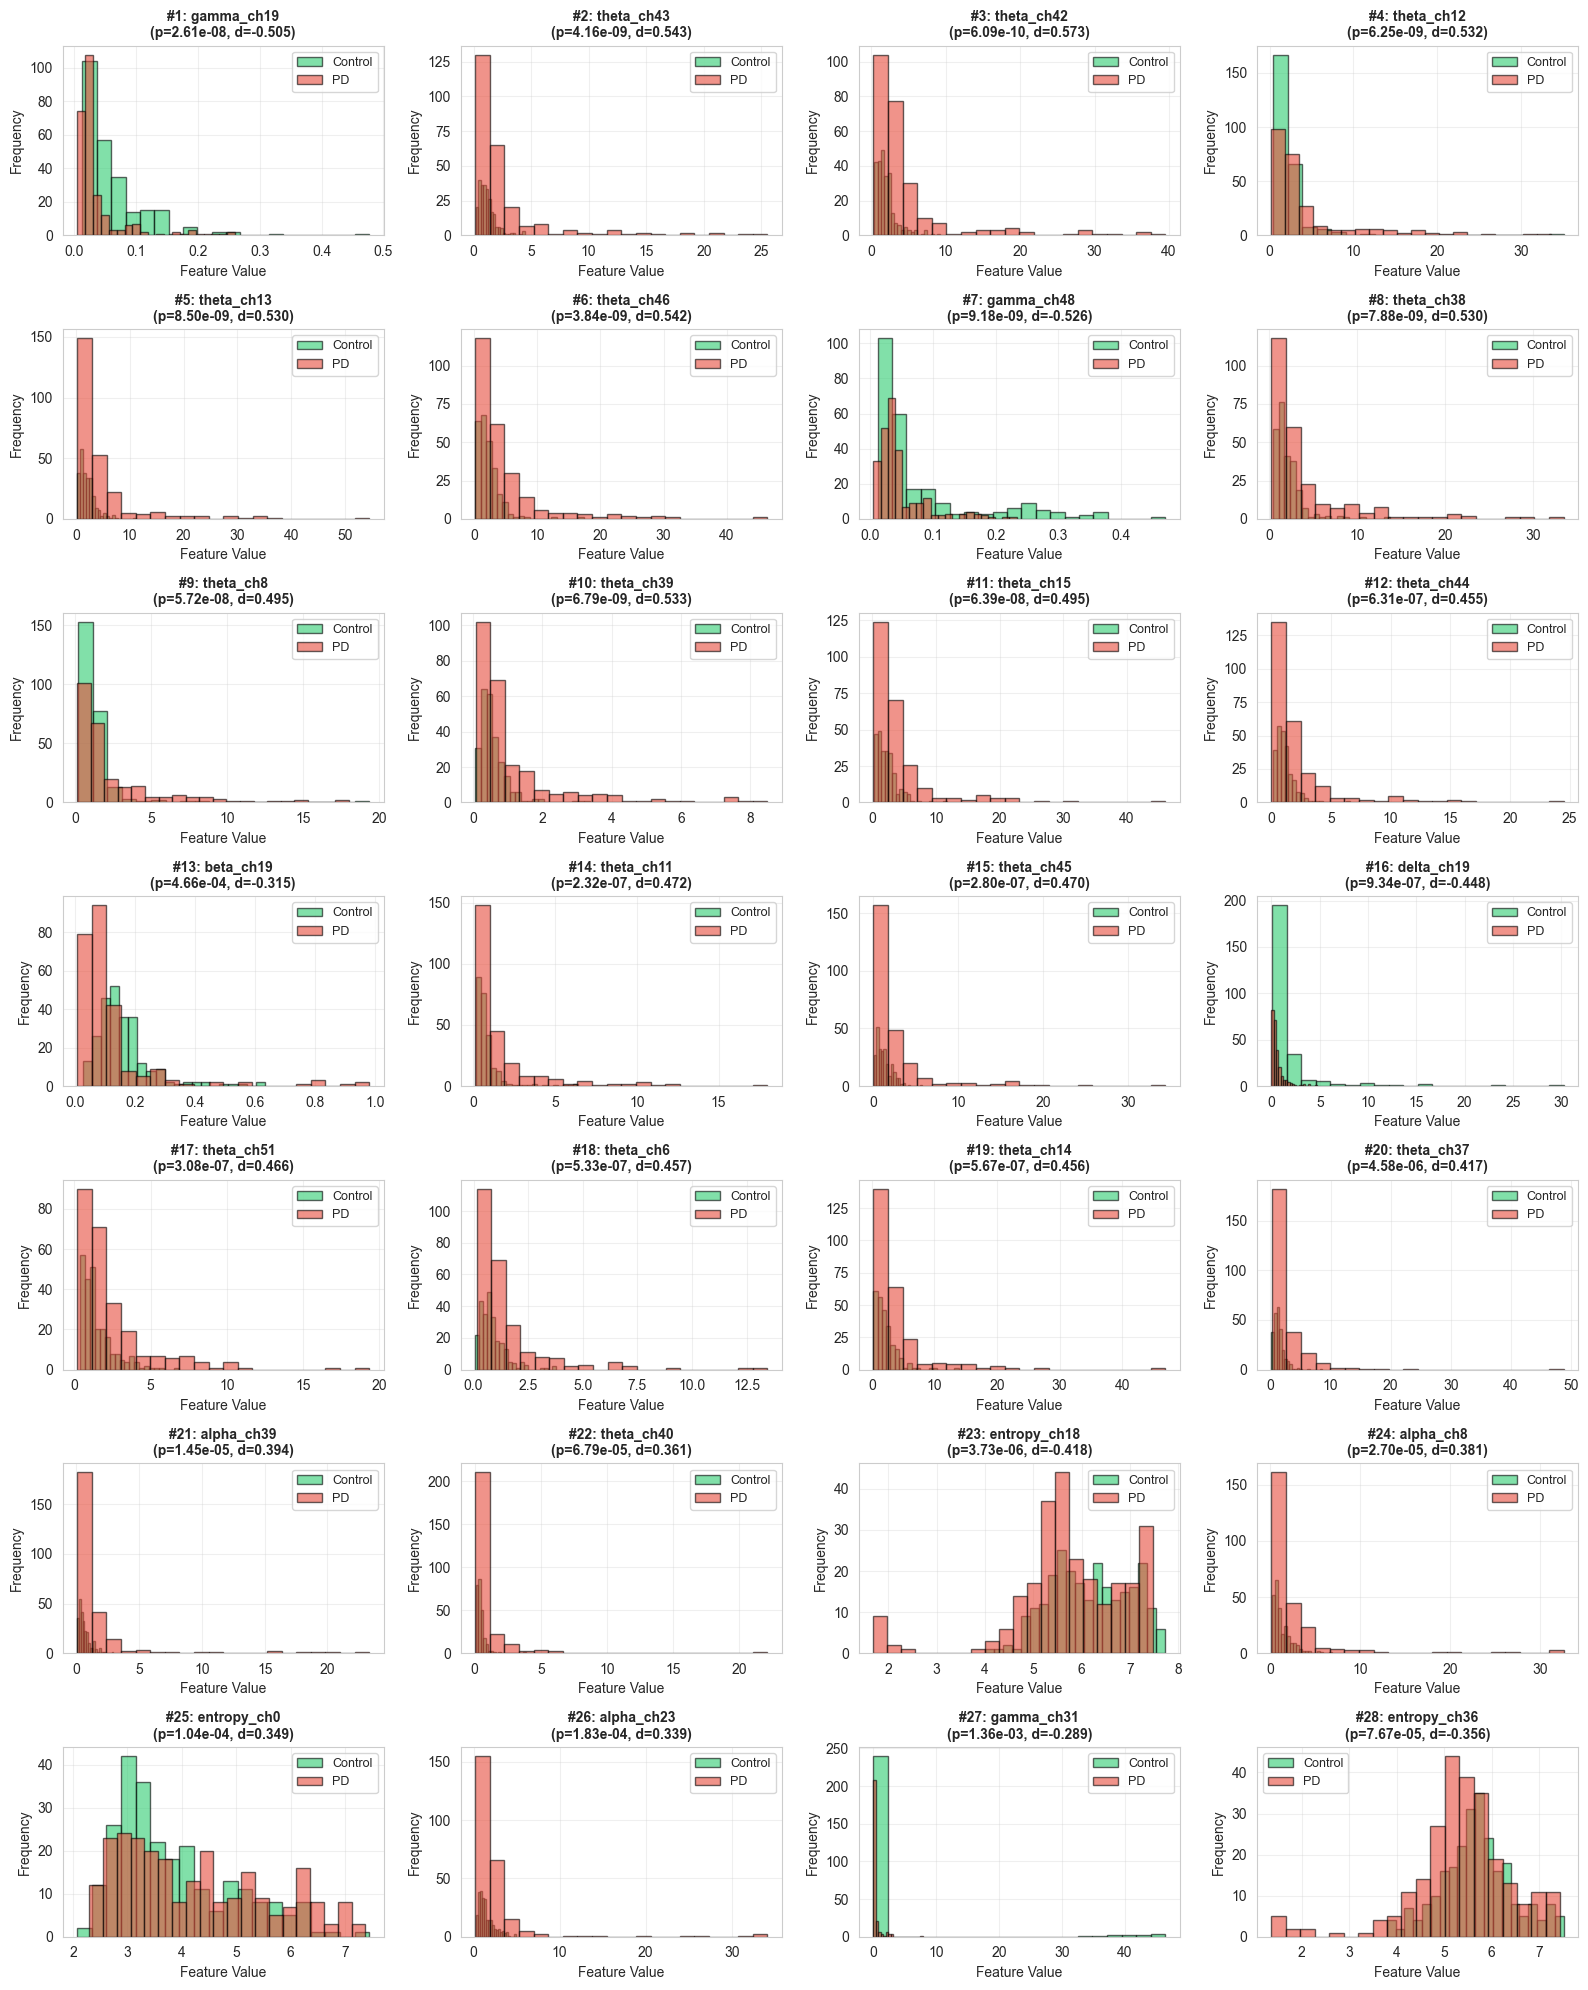

✓ Saved: feature_distributions_top_28.png


In [10]:
# 5. Feature Values Distribution - Top 28 Features
top_28_dist = df_ranked.head(28)

fig, axes = plt.subplots(7, 4, figsize=(16, 20))
axes = axes.ravel()

for idx, (i, row) in enumerate(top_28_dist.iterrows()):
    feat_idx = int(row['feature_idx'])
    
    control_vals = X_all[y_all == 0, feat_idx]
    pd_vals = X_all[y_all == 1, feat_idx]
    
    axes[idx].hist(control_vals, bins=20, alpha=0.6, label='Control', color='#2ecc71', edgecolor='black')
    axes[idx].hist(pd_vals, bins=20, alpha=0.6, label='PD', color='#e74c3c', edgecolor='black')
    axes[idx].set_xlabel('Feature Value', fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].set_title(f"#{idx+1}: {row['name']}\n(p={row['p_value']:.2e}, d={row['cohens_d']:.3f})", 
                        fontsize=10, fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'feature_distributions_top_28.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: feature_distributions_top_28.png")


## 10. Channel-Band Analysis: Detailed Spatial Patterns


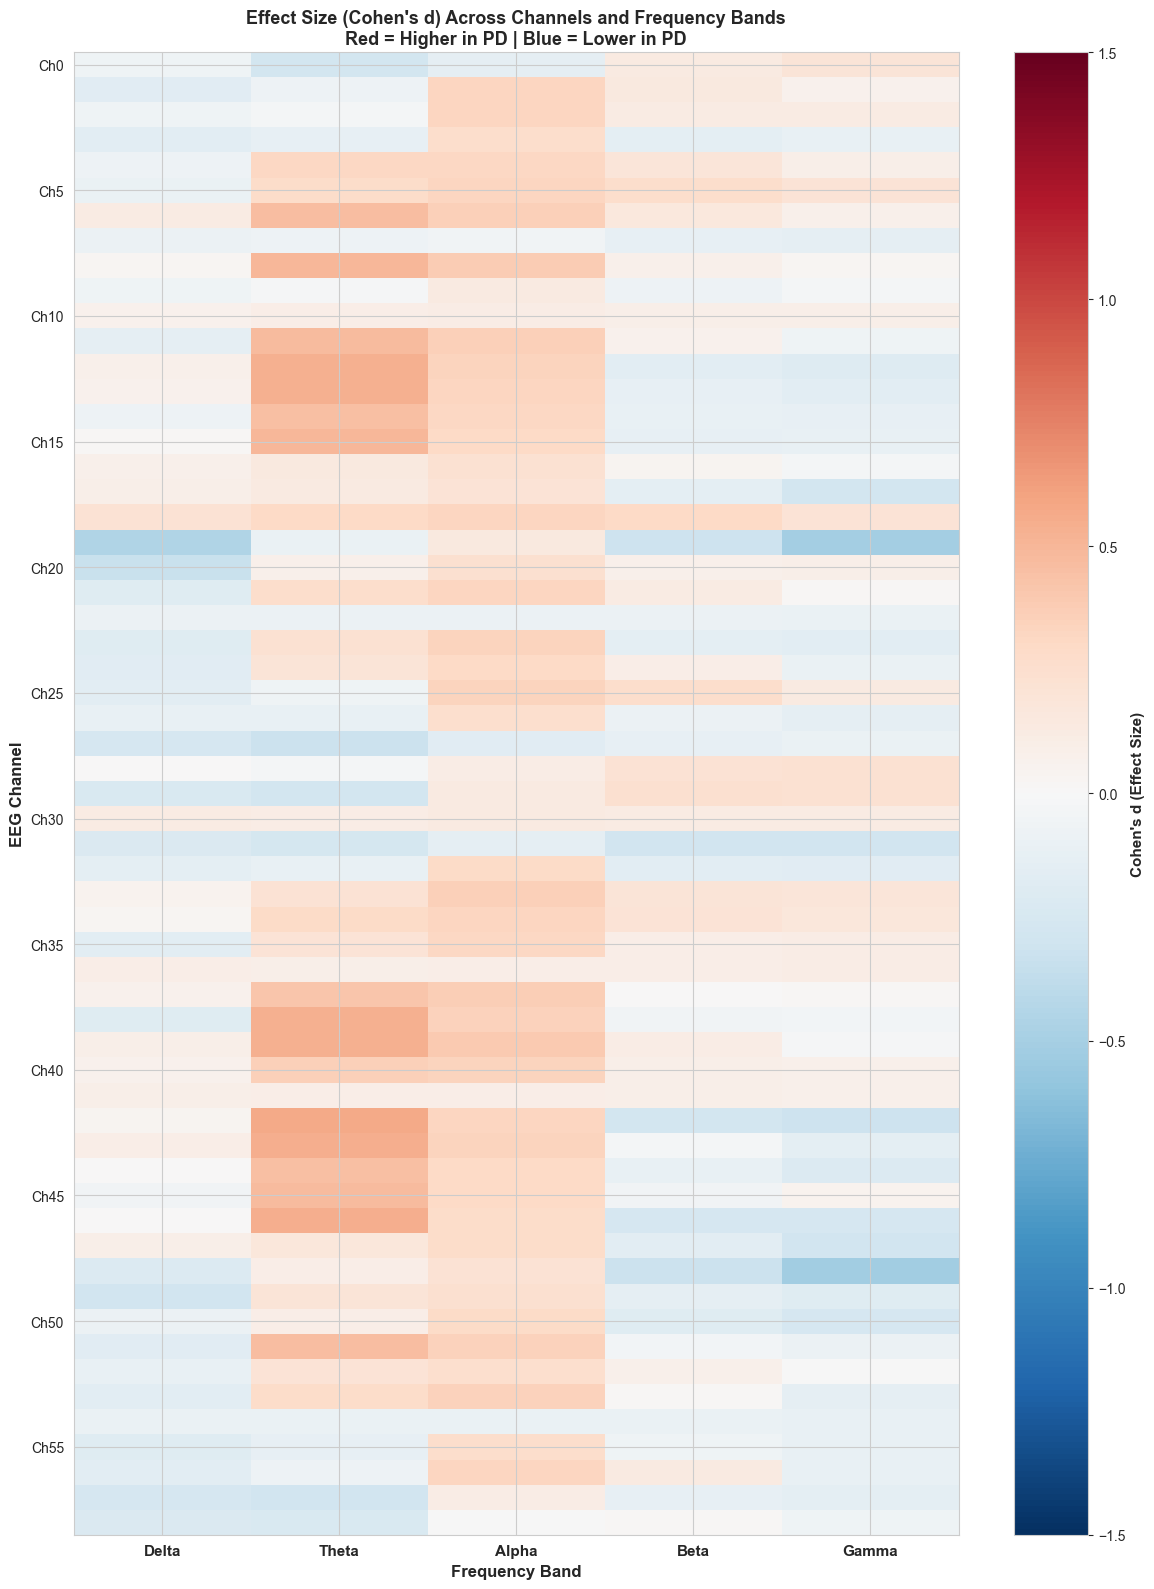

✓ Saved: channel_band_heatmap_cohens_d.png

This heatmap shows:
  - RED regions: Frequency bands HIGHER in PD patients
  - BLUE regions: Frequency bands LOWER in PD patients
  - Each row is a channel (0-58)
  - Each column is a frequency band (delta, theta, alpha, beta, gamma)


In [11]:
# Create a matrix showing effect sizes (Cohen's d) for each channel-band combination
# This shows WHERE in the brain different frequencies are affected by PD

band_names = ['delta', 'theta', 'alpha', 'beta', 'gamma']
n_channels = 59

# Initialize matrix: rows=channels, cols=bands
cohens_d_matrix = np.zeros((n_channels, len(band_names)))
p_value_matrix = np.ones((n_channels, len(band_names)))
mi_matrix = np.zeros((n_channels, len(band_names)))

# Fill the matrix with effect sizes
for band_idx, band_name in enumerate(band_names):
    band_features = df_stats[df_stats['band'] == band_name]
    for _, row in band_features.iterrows():
        ch = int(row['channel'])
        cohens_d_matrix[ch, band_idx] = row['cohens_d']
        p_value_matrix[ch, band_idx] = row['p_value']
        mi_matrix[ch, band_idx] = row['mi_score']

# Visualize: Heatmap of effect sizes across channels and bands
fig, ax = plt.subplots(figsize=(12, 16))

im = ax.imshow(cohens_d_matrix, cmap='RdBu_r', aspect='auto', vmin=-1.5, vmax=1.5)
ax.set_xlabel('Frequency Band', fontsize=12, fontweight='bold')
ax.set_ylabel('EEG Channel', fontsize=12, fontweight='bold')
ax.set_xticks(range(len(band_names)))
ax.set_xticklabels([b.capitalize() for b in band_names], fontsize=11, fontweight='bold')
ax.set_yticks(range(0, n_channels, 5))
ax.set_yticklabels([f'Ch{i}' for i in range(0, n_channels, 5)], fontsize=10)
ax.set_title("Effect Size (Cohen's d) Across Channels and Frequency Bands\nRed = Higher in PD | Blue = Lower in PD", 
             fontsize=13, fontweight='bold')

cbar = plt.colorbar(im, ax=ax, label="Cohen's d")
cbar.set_label("Cohen's d (Effect Size)", fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(output_dir / 'channel_band_heatmap_cohens_d.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: channel_band_heatmap_cohens_d.png")
print("\nThis heatmap shows:")
print("  - RED regions: Frequency bands HIGHER in PD patients")
print("  - BLUE regions: Frequency bands LOWER in PD patients")
print("  - Each row is a channel (0-58)")
print("  - Each column is a frequency band (delta, theta, alpha, beta, gamma)")


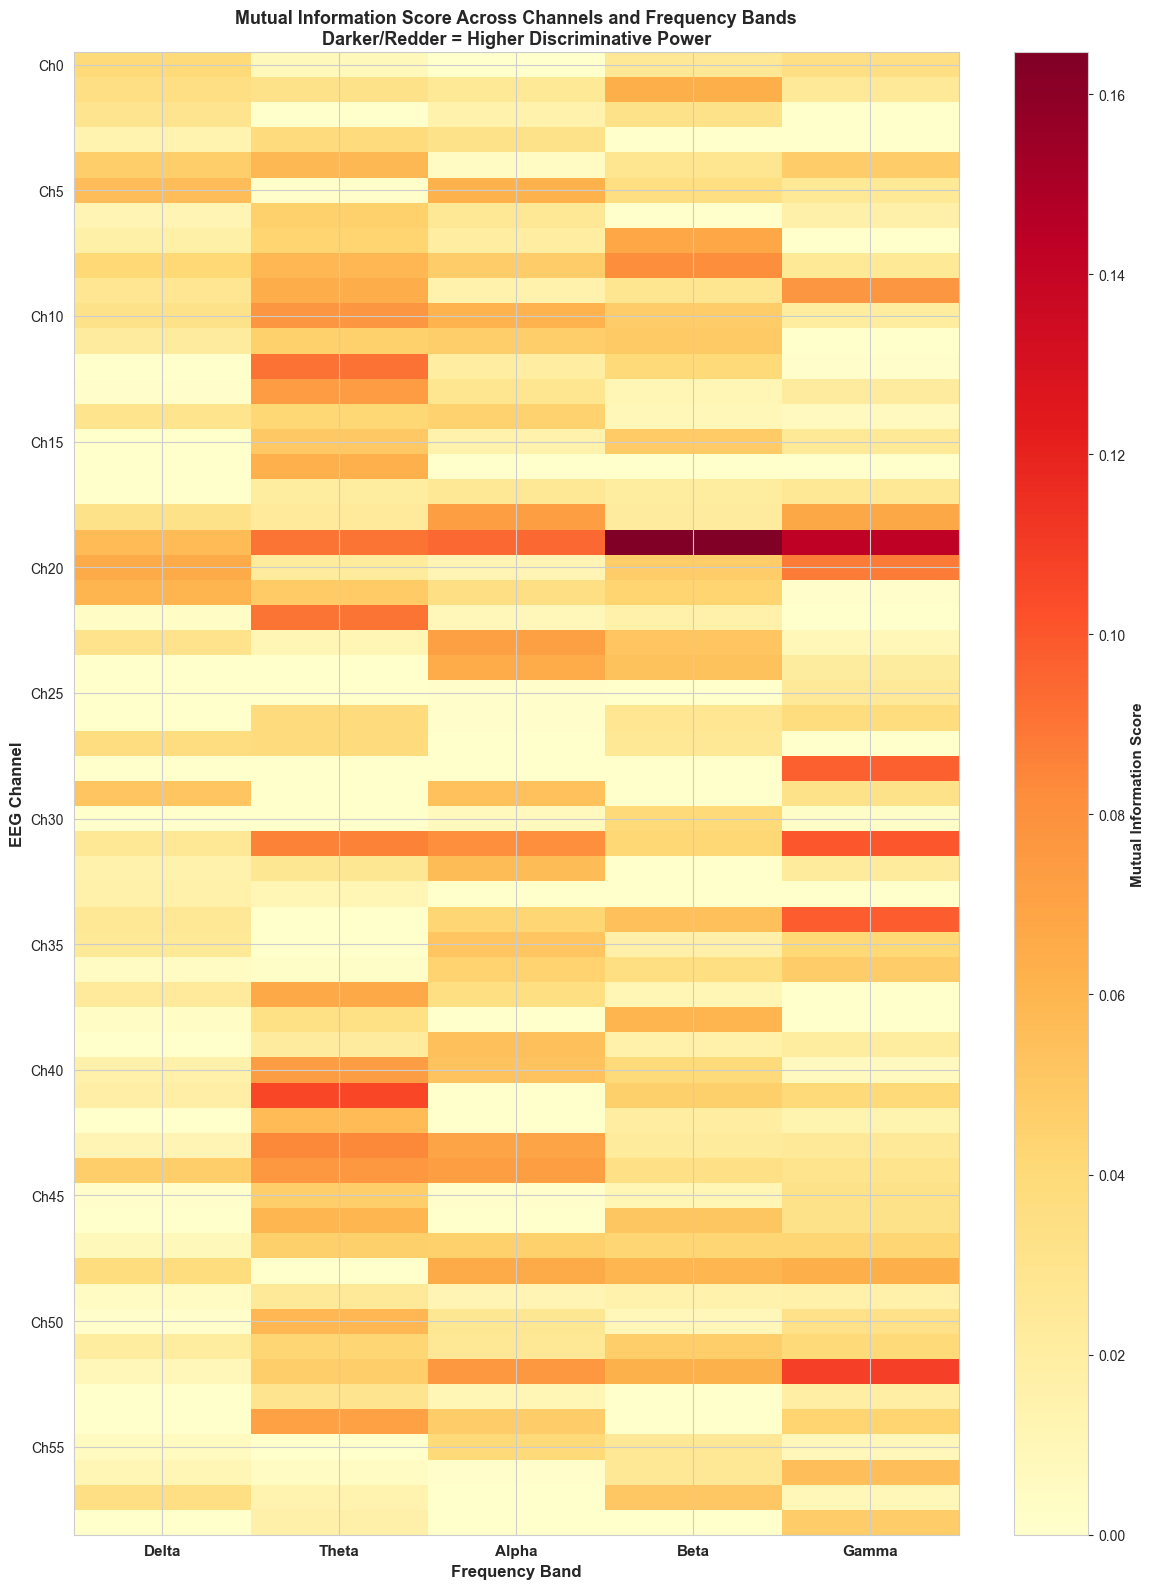

✓ Saved: channel_band_heatmap_mi.png

This heatmap shows:
  - Darker/Redder regions: Higher information content for PD classification
  - Identifies which channel-band combinations are most useful for distinguishing PD


In [12]:
# Heatmap of Mutual Information across channels and bands
fig, ax = plt.subplots(figsize=(12, 16))

im = ax.imshow(mi_matrix, cmap='YlOrRd', aspect='auto')
ax.set_xlabel('Frequency Band', fontsize=12, fontweight='bold')
ax.set_ylabel('EEG Channel', fontsize=12, fontweight='bold')
ax.set_xticks(range(len(band_names)))
ax.set_xticklabels([b.capitalize() for b in band_names], fontsize=11, fontweight='bold')
ax.set_yticks(range(0, n_channels, 5))
ax.set_yticklabels([f'Ch{i}' for i in range(0, n_channels, 5)], fontsize=10)
ax.set_title('Mutual Information Score Across Channels and Frequency Bands\nDarker/Redder = Higher Discriminative Power', 
             fontsize=13, fontweight='bold')

cbar = plt.colorbar(im, ax=ax, label='MI Score')
cbar.set_label('Mutual Information Score', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(output_dir / 'channel_band_heatmap_mi.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: channel_band_heatmap_mi.png")
print("\nThis heatmap shows:")
print("  - Darker/Redder regions: Higher information content for PD classification")
print("  - Identifies which channel-band combinations are most useful for distinguishing PD")


## Figure 1

In [13]:
# Pick one example subject
example = train_data[0]   # or any index you like
eeg = example.data        # shape: (channels, samples)

fs = 500  # your sampling rate
channel_idx = 0  # choose a representative channel
signal = eeg[channel_idx]


In [14]:
t = np.arange(len(signal)) / fs
duration = 5  # seconds
samples = int(duration * fs)

In [15]:
from scipy.signal import welch

freqs, psd = welch(signal, fs=fs, nperseg=fs*2)


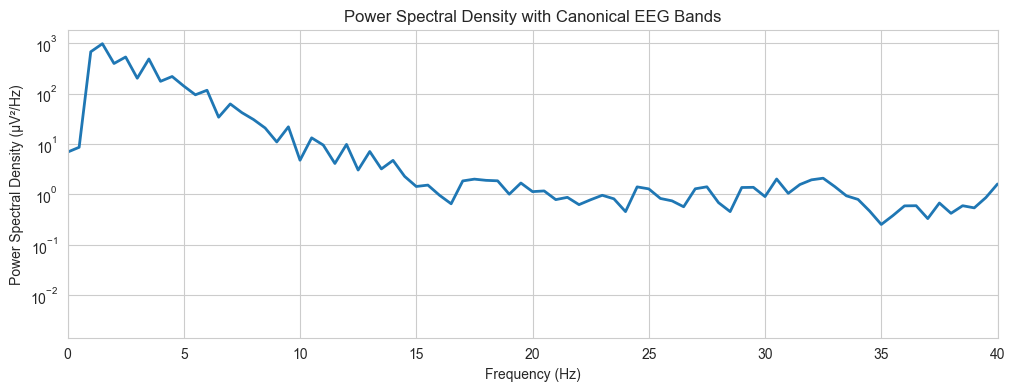

In [16]:
plt.figure(figsize=(12, 4))
plt.semilogy(freqs, psd, linewidth=2)
plt.xlim(0, 40)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (µV²/Hz)")
plt.title("Power Spectral Density with Canonical EEG Bands")

# Shade frequency bands
bands = {
    "Delta (1–4 Hz)": (1, 4, '#d62728'),
    "Theta (4–8 Hz)": (4, 8, '#ff7f0e'),
    "Alpha (8–13 Hz)": (8, 13, '#2ca02c'),
    "Beta (13–30 Hz)": (13, 30, '#1f77b4'),
    "Gamma (30–45 Hz)": (30, 45, '#9467bd')
}


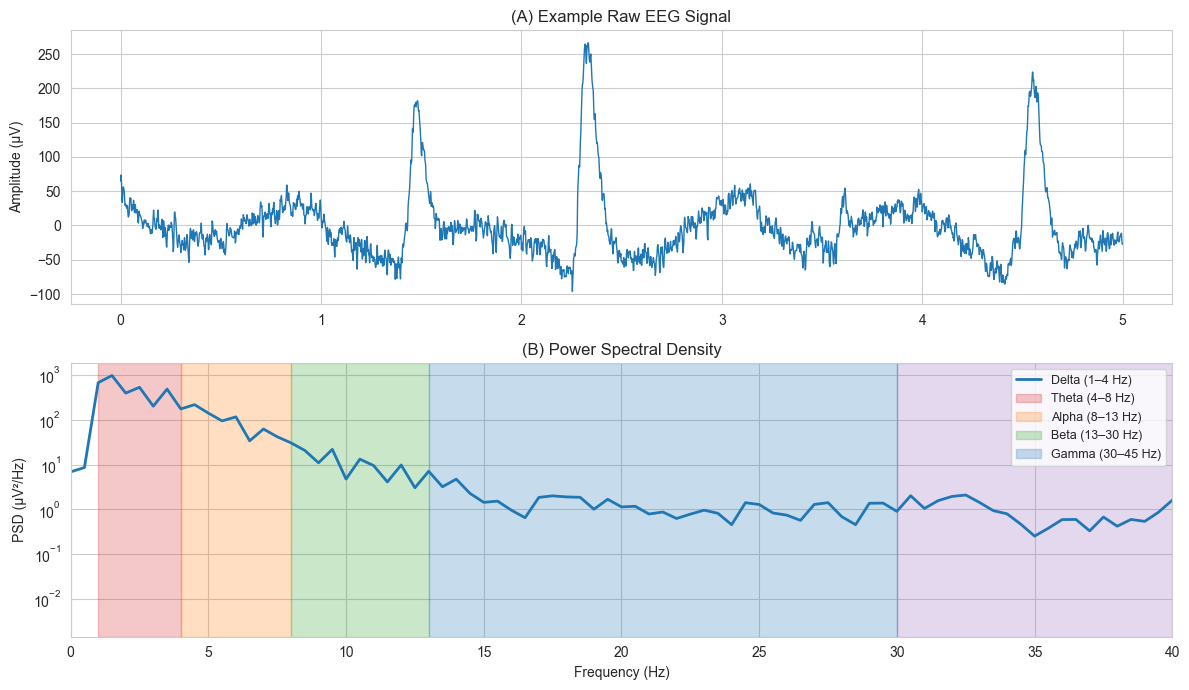

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=False)

# Panel A: Raw EEG
axes[0].plot(t[:samples], signal[:samples], linewidth=1)
axes[0].set_ylabel("Amplitude (µV)")
axes[0].set_title("(A) Example Raw EEG Signal")

# Panel B: PSD
axes[1].semilogy(freqs, psd, linewidth=2)
axes[1].set_xlim(0, 40)
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("PSD (µV²/Hz)")
axes[1].set_title("(B) Power Spectral Density")

for label, (fmin, fmax, color) in bands.items():
    axes[1].axvspan(fmin, fmax, alpha=0.25, color=color)

axes[1].legend(bands.keys(), fontsize=9)

plt.tight_layout()
plt.savefig("eeg_time_psd_example.png", dpi=300, bbox_inches="tight")
plt.show()
